In [1]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

Входные изображения имею диапазон [0, 1].
Мы превратим его в [-1, 1].
Загрузим тренировочный и тестовый датасет при помощи втроенных утилит
Определим семплер для данных



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #Приводит диапазон значений входных тензоров от [0,1] к [-1,1] 
#Compose - это метод, который последовательно применяет операции записанные внутри ко входу, т.е. он будет трансформировать изображения
#ToTensor означает, что он превратит входную картинку в тензор.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform) # выкачивает набор данных CIFAR10 в папку ./data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,
                                          shuffle=True, num_workers=2) #использует набор данных выше и строит мини-пакеты по 4 картинки в каждом, в 2 потока, перемешивая их

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Выведем картинки из датасета



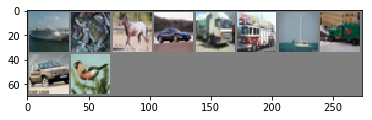

 ship  frog horse   car truck truck  ship truck   car  bird


In [4]:
#Функции для отображения картинок
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Взять несколько случайных элементов и вывести на экран
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Показать изображения и метки к ним
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))

2. Define a Convolutional Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Определим нашу нейронную сеть


In [55]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #параметры свертки число входных каналов, число выходных каналов, размер ядра сверт
        self.conv1 = nn.Conv2d(3, 32, 3)
        #Параметры батчнорма - число каналов
        self.batchnorm1 = nn.BatchNorm2d(32)
        #параметры суб дискретизации  - размер ядра, размер смещения
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.batchnorm4 = nn.BatchNorm2d(256)
        #параметры полносвязного размер входного вектора, размер выходного вектора
        self.fc1 = nn.Linear(1024, 120)
        self.batchnorm6 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.batchnorm7 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)
        self.activation = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.batchnorm1(F.relu(self.conv1(x))))
        x = self.pool(self.batchnorm2(F.relu(self.conv2(x))))
        x = self.batchnorm3(F.relu(self.conv3(x)))
        x = self.batchnorm4(F.relu(self.conv4(x)))
        x = x.view(-1, 1024)
        x = F.relu(self.batchnorm6(self.fc1(x)))
        x = F.relu(self.batchnorm7(self.fc2(x)))
        x = self.activation(self.fc3(x))
        return x


net = Net()

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Определим ошибку и оптимизатор



In [56]:
import torch.optim as optim

#Ошибка кросс энтропии без логарифа
criterion = nn.NLLLoss()
#Разновидность оптимизатора градиентного спуска
optimizer = optim.RMSprop(net.parameters(), lr=0.00001)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

Тренируем сеть в 100 эпох


In [57]:
start_ep = 0
try:
    dicti = torch.load("./checkpoint.ckpt")
    net.load_state_dict(dicti["net"])
    start_ep = dicti["epoch"]
    optimizer.load_state_dict(dicti["optim"])
except:
    print("no save found")
print(start_ep)
for epoch in range(start_ep,20):  # Проход в 100 эпох

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        #Получить данные
        inputs, labels = data

        #Занулить градиенты
        optimizer.zero_grad()

        # forward + backward + optimize
        #Берем логарифм от выхода для ошибки
        outputs = torch.log(net(inputs))
        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        

        running_loss += loss.item()
        if i % 100 == 99:    # вывести на каждом 100 батче
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    #Сохраняем модель, эпоху и параметры оптимизатора
    torch.save({"net":net.state_dict(), "epoch":epoch+1, "optim":optimizer.state_dict()}, "./checkpoint.ckpt")

print('Finished Training')

no save found
0
[1,   100] loss: 0.102
[1,   200] loss: 0.094
[1,   300] loss: 0.094
[1,   400] loss: 0.090
[1,   500] loss: 0.088
[1,   600] loss: 0.088
[1,   700] loss: 0.083
[1,   800] loss: 0.084
[1,   900] loss: 0.085
[1,  1000] loss: 0.081
[1,  1100] loss: 0.080
[1,  1200] loss: 0.080
[1,  1300] loss: 0.079
[1,  1400] loss: 0.080
[1,  1500] loss: 0.079
[1,  1600] loss: 0.076
[1,  1700] loss: 0.075
[1,  1800] loss: 0.078
[1,  1900] loss: 0.075
[1,  2000] loss: 0.072
[1,  2100] loss: 0.075
[1,  2200] loss: 0.074
[1,  2300] loss: 0.074
[1,  2400] loss: 0.074
[1,  2500] loss: 0.073
[1,  2600] loss: 0.074
[1,  2700] loss: 0.072
[1,  2800] loss: 0.073
[1,  2900] loss: 0.071
[1,  3000] loss: 0.072
[1,  3100] loss: 0.072
[1,  3200] loss: 0.071
[1,  3300] loss: 0.070
[1,  3400] loss: 0.072
[1,  3500] loss: 0.072
[1,  3600] loss: 0.065
[1,  3700] loss: 0.069
[1,  3800] loss: 0.072
[1,  3900] loss: 0.066
[1,  4000] loss: 0.072
[1,  4100] loss: 0.069
[1,  4200] loss: 0.067
[1,  4300] loss: 0

[8,   700] loss: 0.031
[8,   800] loss: 0.028
[8,   900] loss: 0.029
[8,  1000] loss: 0.030
[8,  1100] loss: 0.029
[8,  1200] loss: 0.031
[8,  1300] loss: 0.030
[8,  1400] loss: 0.029
[8,  1500] loss: 0.031
[8,  1600] loss: 0.028
[8,  1700] loss: 0.030
[8,  1800] loss: 0.030
[8,  1900] loss: 0.033
[8,  2000] loss: 0.030
[8,  2100] loss: 0.029
[8,  2200] loss: 0.031
[8,  2300] loss: 0.032
[8,  2400] loss: 0.032
[8,  2500] loss: 0.030
[8,  2600] loss: 0.032
[8,  2700] loss: 0.030
[8,  2800] loss: 0.032
[8,  2900] loss: 0.030
[8,  3000] loss: 0.030
[8,  3100] loss: 0.032
[8,  3200] loss: 0.032
[8,  3300] loss: 0.029
[8,  3400] loss: 0.032
[8,  3500] loss: 0.029
[8,  3600] loss: 0.035
[8,  3700] loss: 0.032
[8,  3800] loss: 0.032
[8,  3900] loss: 0.029
[8,  4000] loss: 0.030
[8,  4100] loss: 0.033
[8,  4200] loss: 0.032
[8,  4300] loss: 0.032
[8,  4400] loss: 0.032
[8,  4500] loss: 0.030
[8,  4600] loss: 0.032
[8,  4700] loss: 0.033
[8,  4800] loss: 0.032
[8,  4900] loss: 0.031
[8,  5000] 

[15,   300] loss: 0.016
[15,   400] loss: 0.013
[15,   500] loss: 0.016
[15,   600] loss: 0.016
[15,   700] loss: 0.015
[15,   800] loss: 0.016
[15,   900] loss: 0.015
[15,  1000] loss: 0.015
[15,  1100] loss: 0.016
[15,  1200] loss: 0.018
[15,  1300] loss: 0.015
[15,  1400] loss: 0.016
[15,  1500] loss: 0.015
[15,  1600] loss: 0.018
[15,  1700] loss: 0.017
[15,  1800] loss: 0.018
[15,  1900] loss: 0.018
[15,  2000] loss: 0.015
[15,  2100] loss: 0.018
[15,  2200] loss: 0.020
[15,  2300] loss: 0.017
[15,  2400] loss: 0.015
[15,  2500] loss: 0.017
[15,  2600] loss: 0.017
[15,  2700] loss: 0.016
[15,  2800] loss: 0.019
[15,  2900] loss: 0.018
[15,  3000] loss: 0.019
[15,  3100] loss: 0.017
[15,  3200] loss: 0.018
[15,  3300] loss: 0.017
[15,  3400] loss: 0.018
[15,  3500] loss: 0.018
[15,  3600] loss: 0.019
[15,  3700] loss: 0.017
[15,  3800] loss: 0.015
[15,  3900] loss: 0.020
[15,  4000] loss: 0.020
[15,  4100] loss: 0.016
[15,  4200] loss: 0.020
[15,  4300] loss: 0.017
[15,  4400] loss

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Тестируем сеть, смотрим, как отличаются реальные метки от предсказанных



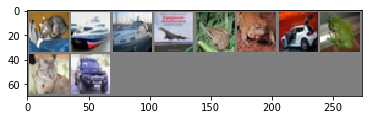

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car
Predicted:    cat  ship  ship plane  deer  frog   car horse   cat   car


In [58]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))
#Сравнить с тем, что выдает сеть
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(10)))

In [59]:
#Смотрим какая ошибка по всему тестовому датасету.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 66 %


In [60]:
#Ошибка по каждому классу
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 70 %
Accuracy of   car : 78 %
Accuracy of  bird : 55 %
Accuracy of   cat : 47 %
Accuracy of  deer : 61 %
Accuracy of   dog : 59 %
Accuracy of  frog : 76 %
Accuracy of horse : 68 %
Accuracy of  ship : 70 %
Accuracy of truck : 77 %
